# Chapter 2: Real-Estate Project

## Import all modules

In [119]:
import os
import tarfile
import urllib
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

## Some useful functions

In [2]:
# Show the results of a K-fold validation
def show_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

## Fetch the data

In [3]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [4]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
# fetch_housing_data(HOUSING_URL, HOUSING_PATH);   # we only need this once
housing = load_housing_data(HOUSING_PATH);

## Inspect the data structure

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Attribute adder class

In [9]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

In [10]:
# Normalize the number of (bed) rooms and the population to sensible values
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

## Plot all of the data

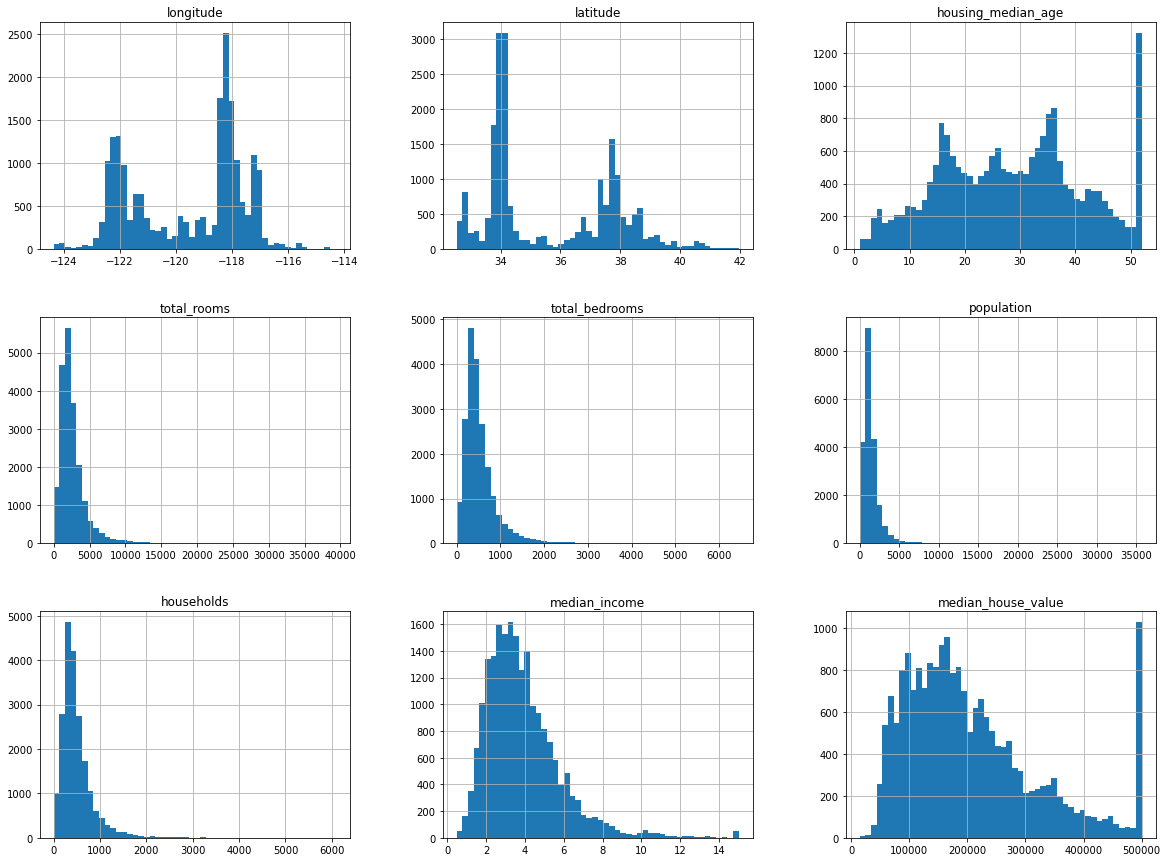

In [11]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

## Create the training and test sets

We want to split the test set with as little selection bias as possible

<AxesSubplot:>

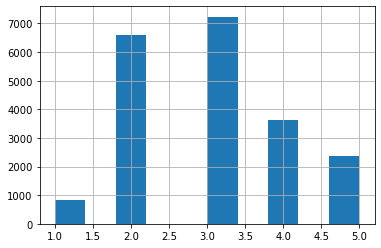

In [12]:
# Get the distribution of the median income in the dataset
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5]);
housing["income_cat"].hist()

In [13]:
# Split the dataset according to the distribution of the median income
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=7);
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [14]:
# Check whether the distribution of the median income in the full dataset and in the test dataset are similar
print(strat_train_set.shape)
print(strat_test_set.shape)
print(housing["income_cat"].value_counts() / len(housing))
print(strat_train_set["income_cat"].value_counts() / len(strat_train_set))
print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))
housing.drop('income_cat', axis=1, inplace=True);
strat_train_set.drop('income_cat', axis=1, inplace=True);
strat_test_set.drop('income_cat', axis=1, inplace=True);

(16512, 11)
(4128, 11)
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64
3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64
3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64


## Visualize the training data

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

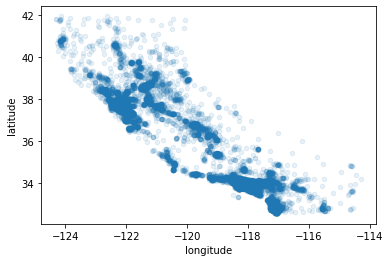

In [15]:
housingTraining = strat_train_set.copy();
housingTraining.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

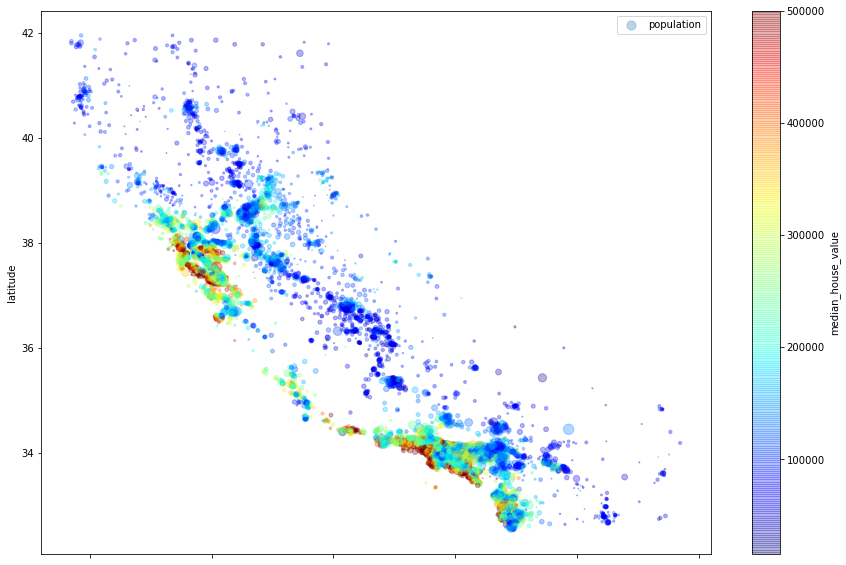

In [16]:
housingTraining.plot(kind='scatter', x='longitude', y='latitude', label='population', alpha=0.3, s=housingTraining['population']/100, c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True, figsize=(15,10))
plt.legend()

## Check for correlations

In [17]:
corrMatrix = housingTraining.corr()

In [18]:
corrMatrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.686222
total_rooms           0.134988
housing_median_age    0.109193
households            0.065806
total_bedrooms        0.050134
population           -0.024929
longitude            -0.045711
latitude             -0.145698
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='total_rooms', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_house_value'

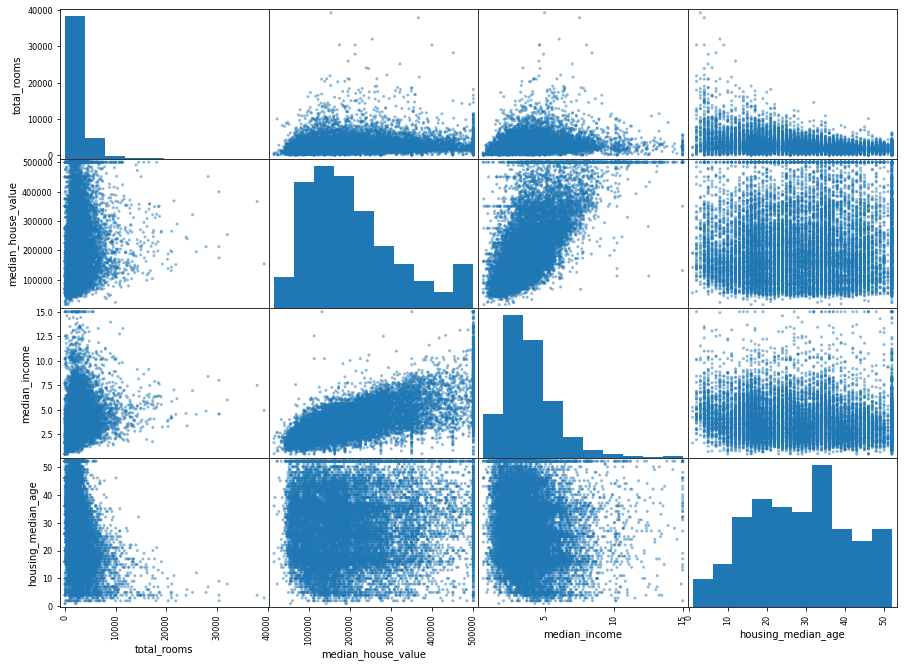

In [19]:
chosenAttr = {'median_house_value', 'median_income', 'total_rooms', 'housing_median_age'};
pd.plotting.scatter_matrix(housingTraining[chosenAttr], figsize=(15,11))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

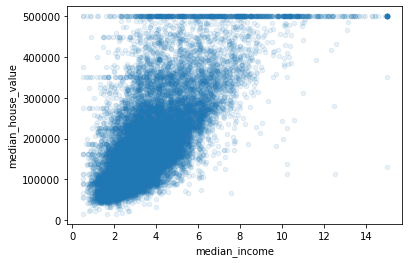

In [20]:
housingTraining.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

In [21]:
# Normalize the number of (bed) rooms and the population to sensible values
#housingTraining['rooms_per_household'] = housingTraining['total_rooms']/housingTraining['households'];
#housingTraining['bedrooms_per_room'] = housingTraining['total_bedrooms']/housingTraining['total_rooms'];
#housingTraining['population_per_household'] = housingTraining['population']/housingTraining['households'];
#housingTraining.corr()['median_house_value'].sort_values(ascending=False)

## Cleaning the data

In [22]:
# Extract the labels from the test set
housingTraining = strat_train_set.drop('median_house_value', axis=1);
housingTraining_labels = strat_train_set['median_house_value'].copy();

### Manual cleaning

In [23]:
# Drop all non-numerical values of the test set and compute the median of all numerical values
# (used for replacing NaN values in the dataset)
imputer = SimpleImputer(strategy='median');
housingTrainingNumOnly = housingTraining.drop('ocean_proximity', axis=1);
imputer.fit(housingTrainingNumOnly);
print(imputer.statistics_)

[-118.5       34.26      29.      2125.       435.      1166.
  409.         3.53665]


In [24]:
X = pd.DataFrame(
    imputer.transform(housingTrainingNumOnly),
    columns=housingTrainingNumOnly.columns,
    index=housingTrainingNumOnly.index
);

In [25]:
# Check the values of the categorical variables
print(housingTraining['ocean_proximity'].unique())

['INLAND' 'NEAR OCEAN' '<1H OCEAN' 'NEAR BAY' 'ISLAND']


In [26]:
# Convert the categorical variables to numerical ones by one-hot encoding
housingTrainingCategorical = housingTraining[['ocean_proximity']];
housingTrainingCategorical

,ocean_proximity
12448,INLAND
2745,INLAND
2949,INLAND
11792,INLAND
14485,NEAR OCEAN
...,...
11159,<1H OCEAN
8042,<1H OCEAN
11968,INLAND
9105,INLAND


In [27]:
onehotEncoder = OneHotEncoder();
housingTrainingCategoricalEnc = onehotEncoder.fit_transform(housingTrainingCategorical);
housingTrainingCategoricalEnc
onehotEncoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [28]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housingTraining.values)
print(housing_extra_attribs)

[[-114.65 33.6 28.0 ... 'INLAND' 6.5546875 2.6015625]
 [-115.57 32.79 34.0 ... 'INLAND' 5.538461538461538 2.985576923076923]
 [-119.0 35.35 31.0 ... 'INLAND' 4.98469387755102 3.348639455782313]
 ...
 [-117.41 34.0 38.0 ... 'INLAND' 4.203773584905661 3.20188679245283]
 [-118.09 34.63 31.0 ... 'INLAND' 3.8715365239294712 3.1209068010075565]
 [-122.06 36.96 52.0 ... 'NEAR OCEAN' 6.5 2.4]]


### Cleaning via pipeline

Replace NaN values with the median, add additional attributes and scale all features.

In [29]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

In [30]:
num_attribs = list(housingTrainingNumOnly)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

In [31]:
housingTrainingPrepared = full_pipeline.fit_transform(housingTraining)

## A linear regressor model

### Train the model

In [32]:
lin_reg = LinearRegression()
lin_reg.fit(housingTrainingPrepared, housingTraining_labels)

LinearRegression()

### Validate the model on the training data

In [33]:
someData = housingTraining.iloc[5:10]
someDataPrepared = full_pipeline.transform(someData)
someLabels = housingTraining_labels.iloc[5:10]
someLabelsPredicted = lin_reg.predict(someDataPrepared)

print('Predicted labels:', someLabelsPredicted)

Predicted labels: [154017.38118598 242212.56063054  79156.85415646 131342.63598119
 140791.83193733]


In [34]:
print('Actual labels:', list(someLabels))

Actual labels: [88600.0, 179100.0, 65200.0, 151700.0, 150800.0]


In [35]:
labelDiff = []
for x in range(len(someLabels)):
    labelDiff.append((list(someLabelsPredicted)[x]-list(someLabels)[x])/list(someLabels)[x]*100.0)
print('Difference in %:', labelDiff)

Difference in %: [73.83451601125992, 35.23872732023567, 21.406218031374255, -13.419488476475594, -6.636716221927573]


Check the mean square error...

In [36]:
housing_predictions = lin_reg.predict(housingTrainingPrepared)
lin_mse = mean_squared_error(housingTraining_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68026.9814743406

... which is pretty high.

### Cross-validate the model

In [37]:
scores = cross_val_score(lin_reg, housingTrainingPrepared, housingTraining_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_error = np.sqrt(-scores)

In [38]:
show_scores(tree_rmse_error)

Scores: [68954.61292999 69170.03223642 70622.98897983 65054.21959033
 72608.10739815 66666.66920782 68384.35823133 67597.07891674
 66990.21096739 68405.9736758 ]
Mean: 68445.4252133803
Standard deviation: 2009.0024500453462


## A decision tree model

### Train the model

In [39]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housingTrainingPrepared, housingTraining_labels)

DecisionTreeRegressor()

### Evaluate the model

In [40]:
someLabelsPredicted2 = tree_reg.predict(someDataPrepared)

print('Predicted labels:', someLabelsPredicted2)

Predicted labels: [ 88600. 179100.  65200. 151700. 150800.]


In [41]:
print('Actual labels:', list(someLabels))

Actual labels: [88600.0, 179100.0, 65200.0, 151700.0, 150800.0]


In [42]:
labelDiff2 = []
for x in range(len(someLabels)):
    labelDiff2.append((list(someLabelsPredicted2)[x]-list(someLabels)[x])/list(someLabels)[x]*100.0)
print('Difference in %:', labelDiff2)

Difference in %: [0.0, 0.0, 0.0, 0.0, 0.0]


Check the mean square error...

In [43]:
housing_predictions2 = tree_reg.predict(housingTrainingPrepared)
tree_mse = mean_squared_error(housingTraining_labels, housing_predictions2)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

... which is precisely zero - not a good sign, since this indicates overfitting.

### Cross-validate the model

In [44]:
scores2 = cross_val_score(tree_reg, housingTrainingPrepared, housingTraining_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_error2 = np.sqrt(-scores2)

In [45]:
show_scores(tree_rmse_error2)

Scores: [71744.41987935 72289.54916056 68585.95191549 75225.84919804
 70417.0309988  69100.86909491 70851.07957603 70797.79584385
 69007.0690199  72617.66323348]
Mean: 71063.72779204097
Standard deviation: 1909.4538059677511


## A random forest model

### Train the model

In [46]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housingTrainingPrepared, housingTraining_labels)

RandomForestRegressor()

### Evaluate the model

In [47]:
someLabelsPredicted3 = forest_reg.predict(someDataPrepared)

print('Predicted labels:', someLabelsPredicted3)

Predicted labels: [112845. 199602.  64464. 155071. 153406.]


In [48]:
print('Actual labels:', list(someLabels))

Actual labels: [88600.0, 179100.0, 65200.0, 151700.0, 150800.0]


In [49]:
labelDiff3 = []
for x in range(len(someLabels)):
    labelDiff3.append((list(someLabelsPredicted3)[x]-list(someLabels)[x])/list(someLabels)[x]*100.0)
print('Difference in %:', labelDiff3)

Difference in %: [27.364559819413092, 11.447236180904524, -1.1288343558282208, 2.222148978246539, 1.7281167108753315]


Check the mean square error...

In [50]:
housing_predictions3 = forest_reg.predict(housingTrainingPrepared)
forest_mse = mean_squared_error(housingTraining_labels, housing_predictions3)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18588.048843373483

... which is pretty low. A good sign.

### Cross-validate the model

In [51]:
scores3 = cross_val_score(forest_reg, housingTrainingPrepared, housingTraining_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_error3 = np.sqrt(-scores3)

In [52]:
show_scores(tree_rmse_error3)

Scores: [51739.921574   51807.16984186 48128.50003806 47421.51803518
 54790.09664738 50255.06907428 50549.58107969 49075.94239574
 49006.27700499 49251.892096  ]
Mean: 50202.59677871838
Standard deviation: 2043.2076618351218


The mean error is lower than for the previous models, but still significantly higher than the error on the training set, which indicates that the model still overfits.

## A support vector machine with linear kernel

### Train the model

In [53]:
svm_linear_reg = SVR(kernel='linear')
svm_linear_reg.fit(housingTrainingPrepared, housingTraining_labels)

SVR(kernel='linear')

### Evaluate the model

In [54]:
someLabelsPredicted4 = svm_linear_reg.predict(someDataPrepared)

print('Predicted labels:', someLabelsPredicted4)

Predicted labels: [174245.9027554  186616.01362709 163981.41476103 169905.74787189
 177578.30246265]


In [55]:
print('Actual labels:', list(someLabels))

Actual labels: [88600.0, 179100.0, 65200.0, 151700.0, 150800.0]


In [56]:
labelDiff4 = []
for x in range(len(someLabels)):
    labelDiff4.append((list(someLabelsPredicted4)[x]-list(someLabels)[x])/list(someLabels)[x]*100.0)
print('Difference in %:', labelDiff4)

Difference in %: [96.66580446433312, 4.196545855438821, 151.505237363545, 12.001152189777002, 17.757495001757853]


Check the mean square error...

In [57]:
housing_predictions4 = svm_linear_reg.predict(housingTrainingPrepared)
svm_linear_mse = mean_squared_error(housingTraining_labels, housing_predictions4)
svm_linear_rmse = np.sqrt(svm_linear_mse)
svm_linear_rmse

110660.74038981687

... which is pretty high!

### Cross-validate the model

In [58]:
scores4 = cross_val_score(svm_linear_reg, housingTrainingPrepared, housingTraining_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_error4 = np.sqrt(-scores4)

In [59]:
show_scores(tree_rmse_error4)

Scores: [111964.50312731 111343.42026519 108082.08959976 108895.22201889
 116934.68532988 114984.45341563 110215.72771976 113304.56735
 105374.48030212 112196.06910627]
Mean: 111329.5218234825
Standard deviation: 3209.457504590113


The mean error is quite high, so the model is not working very well at the moment.

## A support vector machine with rbf kernel

### Train the model

In [60]:
svm_rbf_reg = SVR(kernel='rbf')
svm_rbf_reg.fit(housingTrainingPrepared, housingTraining_labels)

SVR()

### Evaluate the model

In [65]:
someLabelsPredicted5 = svm_rbf_reg.predict(someDataPrepared)

print('Predicted labels:', someLabelsPredicted4)

Predicted labels: [179657.93719938 180791.14007862 179379.88035493 179527.57855358
 180097.01638656]


In [66]:
print('Actual labels:', list(someLabels))

Actual labels: [88600.0, 179100.0, 65200.0, 151700.0, 150800.0]


In [67]:
labelDiff5 = []
for x in range(len(someLabels)):
    labelDiff5.append((list(someLabelsPredicted5)[x]-list(someLabels)[x])/list(someLabels)[x]*100.0)
print('Difference in %:', labelDiff4)

Difference in %: [102.77419548462248, 0.9442434833161579, 175.122515881796, 18.34382238205549, 19.42772969930893]


Check the mean square error...

In [69]:
housing_predictions5 = svm_rbf_reg.predict(housingTrainingPrepared)
svm_rbf_mse = mean_squared_error(housingTraining_labels, housing_predictions5)
svm_rbf_rmse = np.sqrt(svm_rbf_mse)
svm_rbf_rmse

118094.09500505828

... which is pretty high!

### Cross-validate the model

In [70]:
scores5 = cross_val_score(svm_rbf_reg, housingTrainingPrepared, housingTraining_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_error5 = np.sqrt(-scores5)

In [71]:
show_scores(tree_rmse_error5)

Scores: [118347.71220094 117875.0168767  114759.98631768 115822.24400732
 123684.80765472 122205.77176141 117349.5026637  120236.5066523
 111636.25211343 118901.87083803]
Mean: 118081.96710862401
Standard deviation: 3347.4015214030783


The mean error is quite high, so the model is not working very well at the moment.

## Perform a grid search on the random forest

In [84]:
param_grid = [
    {
        'n_estimators': [3, 10, 30, 40, 60, 100, 120],
        'max_features': [2, 4, 6, 8]
    },
    {
        'bootstrap': [False],
        'n_estimators': [3, 10, 60, 120],
        'max_features': [2, 3, 4]
    }
]

In [85]:
forest_reg = RandomForestRegressor()

In [86]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housingTrainingPrepared, housingTraining_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30, 40, 60, 100, 120]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10, 60, 120]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [87]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 4, 'n_estimators': 120}

In [88]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

64495.43718481467 {'max_features': 2, 'n_estimators': 3}
55189.52808110906 {'max_features': 2, 'n_estimators': 10}
52677.295825395304 {'max_features': 2, 'n_estimators': 30}
52586.776168398086 {'max_features': 2, 'n_estimators': 40}
51991.45489089033 {'max_features': 2, 'n_estimators': 60}
51646.315139384926 {'max_features': 2, 'n_estimators': 100}
51652.21574141965 {'max_features': 2, 'n_estimators': 120}
60972.07621183723 {'max_features': 4, 'n_estimators': 3}
52944.695995266855 {'max_features': 4, 'n_estimators': 10}
50499.968039180865 {'max_features': 4, 'n_estimators': 30}
50166.24708949165 {'max_features': 4, 'n_estimators': 40}
49884.89674860829 {'max_features': 4, 'n_estimators': 60}
49461.09232077612 {'max_features': 4, 'n_estimators': 100}
49494.624356743014 {'max_features': 4, 'n_estimators': 120}
58648.5414223838 {'max_features': 6, 'n_estimators': 3}
52194.22794405608 {'max_features': 6, 'n_estimators': 10}
50067.76742365681 {'max_features': 6, 'n_estimators': 30}
49989.11

### Check for the relevance of the features

In [99]:
extra_attribs = ['rooms_per_household', 'population_per_household', 'bedrooms_per_room']
attributes = num_attribs + extra_attribs + list(full_pipeline.named_transformers_['cat'].categories_[0])

In [102]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [106]:
sorted(zip(feature_importances, attributes), reverse=True)

[(0.2914581992394563, 'median_income'),
 (0.14219450236635278, 'INLAND'),
 (0.09928014295503348, 'population_per_household'),
 (0.08355989565989466, 'bedrooms_per_room'),
 (0.08324865594161536, 'longitude'),
 (0.07642937913986657, 'latitude'),
 (0.06662324506042404, 'rooms_per_household'),
 (0.043921397489337766, 'housing_median_age'),
 (0.022718458022148193, 'total_rooms'),
 (0.021839731262987064, 'population'),
 (0.019739710406973417, 'total_bedrooms'),
 (0.01964715200395333, 'households'),
 (0.016071232633591018, '<1H OCEAN'),
 (0.008123044946187917, 'NEAR OCEAN'),
 (0.004871125125117453, 'NEAR BAY'),
 (0.00027412774706071693, 'ISLAND')]

## Evaluate the test set for the best model

In [108]:
best_model = grid_search.best_estimator_
best_model

RandomForestRegressor(bootstrap=False, max_features=4, n_estimators=120)

In [110]:
X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

In [111]:
X_test_prepared = full_pipeline.transform(X_test)

In [116]:
final_predictions = best_model.predict(X_test_prepared)

Remaining root mean squared error:

In [120]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47070.14616756226

In [122]:
confidence_interval = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence_interval, len(squared_errors)-1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([44885.78562571, 49157.53827476])